In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
# from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Dense, Input

In [2]:
# Features that will be extracted from the EM data and their shorter handle
wx_params = {
    "temperature_air_mean_200": "temp",
    "wind_speed": "wind",
    "pressure_air_site": "press",
    # "precipitation_height": "precip",
    "sunshine_duration": "sun"
}
outlier_columns=["01228", "02429", "04039", "00656", "00954", "03897", "03946", "00603"]
na_columns = ["00769", "00850", "02437", "00769", "00850", "02303",	"02437", "02564", "03513", "04371"]
# Concatenate all weather parameters into one data frame
wx_dict = {}
for name, handle in wx_params.items():
    wx_dict[handle]=(pd.read_pickle("../data/weather_all_stations/cleaned/"+name+".pkl")).drop(columns=outlier_columns+na_columns)

df = pd.concat(wx_dict.values(), axis=1, ignore_index=False, verify_integrity=True, keys=wx_dict.keys())
df.head()

temp                                          \
                            00102   00161   00164   00183   00198   00232   
2017-01-01 00:00:00+00:00  278.35  268.75  276.65  277.45  270.65  269.45   
2017-01-01 01:00:00+00:00  278.25  268.85  276.75  277.65  270.25  269.25   
2017-01-01 02:00:00+00:00  278.25  269.25  277.05  277.85  269.45  269.05   
2017-01-01 03:00:00+00:00  278.05  269.35  277.15  277.85  269.25  268.55   
2017-01-01 04:00:00+00:00  278.15  269.45  277.55  277.95  268.85  267.85   

                                                           ...   sun        \
                            00282   00298   00303   00342  ... 04177 04271   
2017-01-01 00:00:00+00:00  262.35  277.75  274.75  275.65  ...   0.0   0.0   
2017-01-01 01:00:00+00:00  262.75  277.75  274.65  275.15  ...   0.0   0.0   
2017-01-01 02:00:00+00:00  261.35  277.75  274.35  274.65  ...   0.0   0.0   
2017-01-01 03:00:00+00:00  261.15  277.95  274.55  274.25  ...   0.0   0.0   
2017-01-01 04:00:00+00:00  261.35  277.85  274.75  274.45  ...   0.0   0.0   

                                                                           
                          04336 04393 04464 04466 04501 04625 04642 04745  
2017-01-01 00:00:00+00:00   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2017-01-01 01:00:00+00:00   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2017-01-01 02:00:00+00:00   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2017-01-01 03:00:00+00:00   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2017-01-01 04:00:00+00:00   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 468 columns]

In [3]:
print("column shape: ", df.columns.levshape)
print("df shape: ", df.shape)

column shape:  (4, 117)
df shape:  (43824, 468)


In [4]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
df_train = df[0:int(n*0.7)]
df_val = df[int(n*0.7):int(n*0.9)]
df_test = df[int(n*0.9):]


In [5]:
df_train.shape

(30676, 468)

In [6]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler()
scaler.fit(df_train)
# scale all sets according to train set, preserve data frames
df_train = pd.DataFrame(scaler.transform(df_train),
                        columns=df.columns, index=df_train.index).clip(lower=-3)
df_val = pd.DataFrame(scaler.transform(df_val),
                        columns=df.columns, index=df_val.index)
df_test = pd.DataFrame(scaler.transform(df_test),
                        columns=df.columns, index=df_test.index)
plt.figure(figsize=(12, 6))

# ax = sns.violinplot(x="Parameter", y="Rescaled", data=df_train.melt(var_name='Parameter', value_name='Rescaled'))
# _ = ax.set_xticklabels(df.keys(), rotation=90)

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<AxesSubplot: >

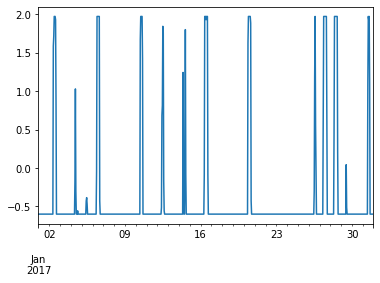

In [7]:
df_train.xs("00183", level=1, axis=1)["sun"].iloc[:31*24].plot()

In [8]:
desc=df_train["wind"].describe().transpose() # .drop(columns=["01228", "02429", "04039", "00656", "00954", "03897", "03946", "00603"]
desc_orig=df["sun"].describe() #

In [9]:
df.columns.levshape
# df.describe()

(4, 117)

In [10]:
latent_dim = 50

X_train = df_train.to_numpy().reshape(-1, *df.columns.levshape)
X_val = df_val.to_numpy().reshape(-1, *df.columns.levshape)
X_test = df_test.to_numpy().reshape(-1, *df.columns.levshape)
input_dim=X_train.shape[1:]

print(input_dim)
print(X_train.shape)
print(df_train.shape)

(4, 117)
(30676, 4, 117)
(30676, 468)


In [11]:
from tensorflow.keras.backend import clear_session

clear_session()
ae=Sequential()
ae.add(layers.Flatten())
ae.add(Dense(latent_dim, input_shape=input_dim,  activation='relu'))
ae.add(Dense(X_train.shape[1]*X_train.shape[2], activation="linear"))
ae.add(layers.Reshape(df.columns.levshape))

# ae.summary()

# plot_model(ae)

In [12]:
# create an input layer with the appropriate shape
input_img = Input(shape=(*input_dim,))
input_lat = Input(shape=(latent_dim,))

# extract the encoder layers
encoder_layer1 = ae.layers[0](input_img)
encoder_layer2 = ae.layers[1](encoder_layer1)

# extract the decoder layers
decoder_layer1 = ae.layers[-2](input_lat)
decoder_layer2 = ae.layers[-1](decoder_layer1)


# make them addressable models
encoder = Model(input_img, encoder_layer2)
decoder = Model(input_lat, decoder_layer2)

encoder.summary()
decoder.summary()

# #plot_model(encoder)
# plot_model(decoder)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 117)]          0         
                                                                 
 flatten (Flatten)           (None, 468)               0         
                                                                 
 dense (Dense)               (None, 50)                23450     
                                                                 
Total params: 23,450
Trainable params: 23,450
Non-trainable params: 0
_________________________________________________________________
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50)]              0         
                                                                 
 dense_1 (Dense)             (None, 468)

In [13]:
ae.compile(optimizer="adam", loss="mse")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=8,
                                                      mode='min',
                                                      verbose=1,
                                                      restore_best_weights=True)
history=ae.fit(X_train, X_train, epochs=100, batch_size=128, shuffle=True, callbacks=[early_stopping], validation_data=(X_val, X_val))

Epoch 1/100
240/240 [==============================] - 1s 1ms/step - loss: 0.3011 - val_loss: 0.1695
Epoch 2/100
240/240 [==============================] - 0s 1ms/step - loss: 0.1469 - val_loss: 0.1353
Epoch 3/100
240/240 [==============================] - 0s 1ms/step - loss: 0.1234 - val_loss: 0.1197
Epoch 4/100
240/240 [==============================] - 0s 1ms/step - loss: 0.1111 - val_loss: 0.1103
Epoch 5/100
240/240 [==============================] - 0s 1ms/step - loss: 0.1025 - val_loss: 0.1029
Epoch 6/100
240/240 [==============================] - 0s 1ms/step - loss: 0.0961 - val_loss: 0.0974
Epoch 7/100
240/240 [==============================] - 0s 1ms/step - loss: 0.0917 - val_loss: 0.0937
Epoch 8/100
240/240 [==============================] - 0s 1ms/step - loss: 0.0885 - val_loss: 0.0909
Epoch 9/100
240/240 [==============================] - 0s 1ms/step - loss: 0.0865 - val_loss: 0.0890
Epoch 10/100
240/240 [==============================] - 0s 1ms/step - loss: 0.0852 - val_lo

(4383, 4, 117)
(4383, 4, 117)
(4383, 468)


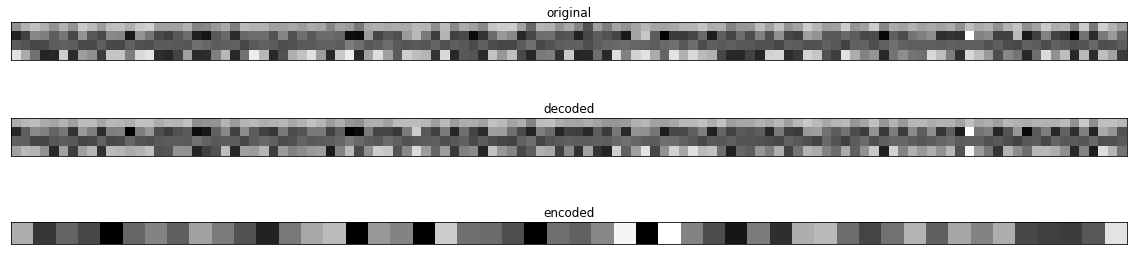

In [14]:
encoded_imgs = encoder(X_test).numpy()
decoded_imgs = decoder(encoded_imgs).numpy()
print(ae.predict(X_test).shape)
print(ae.predict(X_test).reshape(-1, *df.columns.levshape).shape)
print(X_test.reshape(df_test.shape).shape)
transformed_imgs = scaler.inverse_transform(ae.predict(X_test).reshape(df_test.shape)).reshape(-1, *X_test.shape[1:])
# print(reconstructed_imgs[0].shape)
def plot_autoenc(X_test, decoded_imgs, encoded_imgs):
  n = 1
  offset=5
  plt.figure(figsize=(20,5))

  for i in range(n):
    # display original
    ax = plt.subplot(3*n, 1, i + 1)
    # plt.imshow(scaler.inverse_transform(X_test.reshape(df_test.shape))[i+offset].reshape(X_test.shape[1:]))
    plt.imshow(X_test[i+offset])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3*n, 1, i + 2)
    plt.imshow(decoded_imgs[i+offset])
    plt.title("decoded")
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3*n, 1, i + 3)
    plt.imshow(encoded_imgs[i+offset].reshape(latent_dim,1).transpose())
    plt.title("encoded")
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

plot_autoenc(X_test, decoded_imgs, encoded_imgs)

In [16]:
encoded=encoder(scaler.transform(df).reshape(-1, *X_test.shape[1:])).numpy()
enc_df=pd.DataFrame(encoded)
enc_df.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.744072,0.632633,0.0,0.613509,0.263963,0.584664,0.766309,1.301002,0.951287,1.202465,...,1.469427,1.187209,0.910372,1.090632,0.708872,0.451213,1.718016,1.481721,1.360571,0.783143
1,0.772694,0.613933,0.0,0.772452,0.228725,0.690475,0.795224,1.298837,1.070870,0.990702,...,1.411515,1.239759,0.957551,1.103515,0.752096,0.432002,1.769183,1.543759,1.372250,0.885192
2,0.655521,0.400196,0.0,0.743614,0.204449,0.742712,0.819991,1.135661,0.984437,0.823416,...,1.444260,1.140483,1.033767,1.047049,0.796888,0.338251,1.783448,1.315892,1.430196,0.715991
3,0.747894,0.508092,0.0,0.958138,0.195030,0.827871,0.719883,1.355679,1.018030,0.850948,...,1.533720,1.267275,1.076251,1.157449,0.943197,0.343462,1.977618,1.454353,1.564182,0.793921
4,0.722708,0.356521,0.0,0.805240,0.247566,0.859913,0.670428,1.364628,1.087621,0.813409,...,1.549074,1.194806,1.105622,1.064820,0.954739,0.481917,1.859510,1.516427,1.599732,0.820539


In [17]:
# Removing zero-only columns
enc_df = enc_df.loc[:, (enc_df != 0).any(axis=0)]

# Rename columns
num_cols = enc_df.shape[1]
enc_df.columns = ["enc_" + str(i) for i in range(num_cols)]
# Add datetime index
enc_df.index = df.index
enc_df.head()

,enc_0,enc_1,enc_2,enc_3,enc_4,enc_5,enc_6,enc_7,enc_8,enc_9,...,enc_40,enc_41,enc_42,enc_43,enc_44,enc_45,enc_46,enc_47,enc_48,enc_49
2017-01-01 00:00:00+00:00,0.744072,0.632633,0.0,0.613509,0.263963,0.584664,0.766309,1.301002,0.951287,1.202465,...,1.469427,1.187209,0.910372,1.090632,0.708872,0.451213,1.718016,1.481721,1.360571,0.783143
2017-01-01 01:00:00+00:00,0.772694,0.613933,0.0,0.772452,0.228725,0.690475,0.795224,1.298837,1.070870,0.990702,...,1.411515,1.239759,0.957551,1.103515,0.752096,0.432002,1.769183,1.543759,1.372250,0.885192
2017-01-01 02:00:00+00:00,0.655521,0.400196,0.0,0.743614,0.204449,0.742712,0.819991,1.135661,0.984437,0.823416,...,1.444260,1.140483,1.033767,1.047049,0.796888,0.338251,1.783448,1.315892,1.430196,0.715991
2017-01-01 03:00:00+00:00,0.747894,0.508092,0.0,0.958138,0.195030,0.827871,0.719883,1.355679,1.018030,0.850948,...,1.533720,1.267275,1.076251,1.157449,0.943197,0.343462,1.977618,1.454353,1.564182,0.793921
2017-01-01 04:00:00+00:00,0.722708,0.356521,0.0,0.805240,0.247566,0.859913,0.670428,1.364628,1.087621,0.813409,...,1.549074,1.194806,1.105622,1.064820,0.954739,0.481917,1.859510,1.516427,1.599732,0.820539


In [18]:
enc_df.to_pickle("../data/prepared/encoded_weather.pkl")